# Do class-weights and threshold perform the same role in Logistic Regression?

## I. Abstract:

As explained in the question 'Class weights and threshold limit', threshold limit determines the rate of false negativity and false positivity. We guess the excessive false negativity rate as compared to the false positivity rate on using 0.5 as the threshold is due to the imbalance in the dataset - too low $y=1$ samples as compared to $y=0$ samples. It seems logical because $y=0$ samples have greater influence over the classifier as compared to $y=1$ samples. As a result error rates in $y=0$ class is lower compared to $y=1$ class. First, we will put this assumption to test.

If the assumption turns out valid, we will check if manipulating class-weights achieves the same end as manipulating threshold limit.

Hence there will be two parts to this study, namely -
<ul>
    <li>Does false negativity rate depend on dataset imbalance?</li>
    <li>If above answer is yes, do threshold limit and class-weights achieve the same end?</li>
</ul>

## II. Preparing the simulated training data

We first decide the characteristics of the training dataset.

<b>Characteristics of training data:</b>
<ol>
    <li>There will be one feature, credit balance- a number between 0-20,000- and a response- the default status. 1 denotes default=yes and 0 denotes default=no. The training set size will be $n$</li>
    <li>We will take a probability distribution $P(y=1|x)$ such that people with higher credit balance have a higher chance of default.</li>
    <li>In the traning set $\frac {\text{entries with y=1}} {n} = defaultProportion$.</li>
    </ol>
    
We will define a function <b><i>generateTrainingSet(n, defaultProportion, defaultProbabilityDist, xDist, \*args, \*\*kwargs)</i></b> that will generate the training set with given size and proportion of $y=1$ samples.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

For higher credit balance we want a higher probability of default. We use the logistic function, $\frac {e^{{\beta}_0 + {\beta}_1x}} {1+e^{{\beta}_0 + {\beta}_1x}}$, with parameters ${\beta}_0$ and ${\beta}_1$ chosen to meet our requirements.

Below, is the plot of the logistic function thus derived, that returns the probability of default given any credit balance $x$ between 0 and 20000.

In [2]:
defaultProbabilityDist = lambda x: np.exp(-9.952+0.0006319*x)/(1+np.exp(-9.952+0.0006319*x)) 

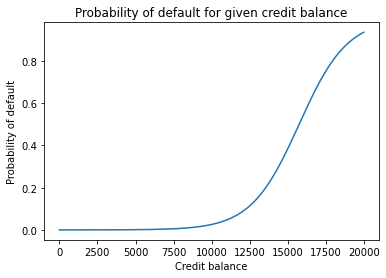

In [3]:
X = np.linspace(0,20000,10000)
Y = [defaultProbabilityDist(x) for x in X]
plt.plot(X,Y)
plt.xlabel('Credit balance')
plt.ylabel('Probability of default')
plt.title('Probability of default for given credit balance');

Below is the function to generate the training set.

In [4]:
def generateTrainingSet(n, defaultProportion, defaultProbabilityDist, xDist, *args, **kwargs):
    trainingSet = pd.DataFrame(columns=['Balance','Default'])
    defaultSize = np.around(n*defaultProportion)
    while len(trainingSet.loc[trainingSet['Default']==0.0]) < n-defaultSize:
        x = xDist(*args, **kwargs)
        p = defaultProbabilityDist(x)
        y = np.random.choice([0,1],p=[(1-p),p])
        if y==0:
            trainingSet.loc[len(trainingSet)] = [x,y]
        if (y==1) and (len(trainingSet.loc[trainingSet['Default']==1.0]) < defaultSize):
            trainingSet.loc[len(trainingSet)] = [x,y]

    while len(trainingSet) < n:
        x = x = xDist(*args, **kwargs)
        p = defaultProbabilityDist(x)
        y = np.random.choice([0,1],p=[(1-p),p])
        if y==1:
            trainingSet.loc[len(trainingSet)] = [x,y]
            
    return trainingSet

In [5]:
trainingSet = generateTrainingSet(1000,0.1,defaultProbabilityDist,np.random.uniform,low=0.0,high=20000)

In [11]:
trainingSet.head()

,Balance,Default
0,9444.112802,0.0
1,5378.944966,0.0
2,15778.867748,0.0
3,2907.466604,0.0
4,15043.977947,1.0


The below figure shows that people with <b>Default status = Yes</b> have, on the average, a higher credit balance. Besides, in the training set, <b>Default status = Yes</b> is only 10% the entire training set. Hence the imbalance we wanted to create is present as well.

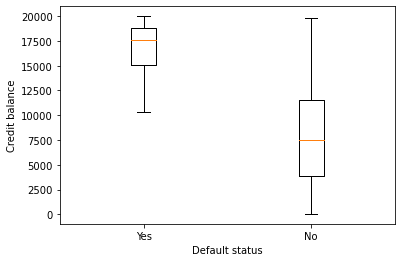

In [6]:
plt.boxplot([trainingSet.loc[trainingSet['Default']==1.0]['Balance'], trainingSet.loc[trainingSet['Default']==0.0]['Balance']],
           labels=['Yes','No'])
plt.xlabel('Default status')
plt.ylabel('Credit balance');

In [7]:
len(trainingSet.loc[trainingSet['Default']==0.0])

900

In [8]:
len(trainingSet.loc[trainingSet['Default']==1.0])

100

## III. Finding the false negativity rate

Applying Logistic Regression to predict the default status.

In [12]:
clf = LogisticRegression().fit(trainingSet[['Balance']],trainingSet['Default'])
trainingSet['Default prediction'] = clf.predict(trainingSet[['Balance']])

In [16]:
clf.classes_

array([0., 1.])

In [13]:
trainingSet

,Balance,Default,Default prediction
0,9444.112802,0.0,0.0
1,5378.944966,0.0,0.0
2,15778.867748,0.0,0.0
3,2907.466604,0.0,0.0
4,15043.977947,1.0,0.0
...,...,...,...
995,6773.634351,0.0,0.0
996,15844.504623,0.0,0.0
997,14617.847761,0.0,0.0
998,17502.691883,0.0,1.0


Producing the confusion matrix

In [22]:
confuMatrix = metrics.confusion_matrix(trainingSet['Default'], trainingSet['Default prediction'],normalize='true')
confusionMatrix = pd.DataFrame(data=confuMatrix, columns=['Predicted 0','Predicted 1'], index=['True 0', 'True 1'])
confusionMatrix

,Predicted 0,Predicted 1
True 0,0.977778,0.022222
True 1,0.440000,0.560000


In [25]:
confuMatrix = metrics.confusion_matrix(trainingSet['Default'], trainingSet['Default prediction'],normalize='all')
print('Overall error rate:', confuMatrix[0,1] + confuMatrix[1,0])

Overall error rate: 0.064


Hence the false negative and true positive rate are 44% and 56% respectively. The false positive rate is 2.22% and overall error rate is 6.4%. We will now study the false negative rate, false positive rate and overall error rate as function of training dataset imbalance (default=yes proportion in training set).

## IV. Error rates vs imbalance in training dataset

In [33]:
def errorRateVsImbalance(numOfPoints,propRange):
    proportions = np.linspace(propRange[0], propRange[1], numOfPoints)
    falseNegRates, falsePosRates, overallErrorRates = [],[],[]
    for prop in proportions:
        trainingSet = generateTrainingSet(1000,prop,defaultProbabilityDist,np.random.uniform,low=0.0,high=20000)
        clf = LogisticRegression().fit(trainingSet[['Balance']],trainingSet['Default'])
        trainingSet['Default prediction'] = clf.predict(trainingSet[['Balance']])
        confuMatrix = metrics.confusion_matrix(trainingSet['Default'], trainingSet['Default prediction'],normalize='true')
        falseNegRates.append(confuMatrix[1,0])
        falsePosRates.append(confuMatrix[0,1])
        confuMatrix = metrics.confusion_matrix(trainingSet['Default'], trainingSet['Default prediction'],normalize='all')
        overallErrorRates.append(confuMatrix[0,1] + confuMatrix[1,0])
    return falseNegRates, falsePosRates, overallErrorRates, proportions

In [48]:
falseNegRates, falsePosRates, overallErrorRates, proportions = errorRateVsImbalance(100,(0.01,0.5))

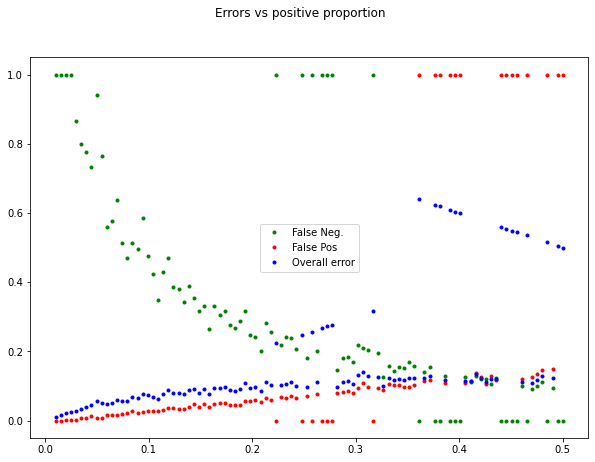

In [183]:
fig = plt.figure(figsize=(10,7))
plt.plot(proportions,falseNegRates,'.g',label='False Neg.')
plt.plot(proportions,falsePosRates,'.r',label='False Pos')
plt.plot(proportions,overallErrorRates,'.b',label='Overall error')
fig.suptitle('Errors vs positive proportion')
plt.legend();

### IV a. Why does the overall error rate increase with increasing balance?

As training dataset goes from imbalance (lower $y=1$ entries) to balance, the false negative rate will decrease. This is logical as model will be more ***learned*** in the $y=1$ domain. So will the false positive rate increase as the model will get comparatively less scope to learn $y=0$ domain. 

However, why is it so that the overall error rate, which denotes the models overall ***learned-ness***, increases. It could have equally stayed the same or decreased.

To answer this question we will take a closer look at the original and predicted decision boundaries, i.e., $x$ values for which $P(y=1|x)=0.5$. The original decision boundary is governed by the distribution used to simulate the training dataset.

In [169]:
orgDecisionBoundary = -(-9.952/0.0006319)

In [181]:
def decisionBoundaries(proportions,orgDecisionBoundary):
    for prop in proportions:
        trainingSet = generateTrainingSet(1000,prop,defaultProbabilityDist,np.random.uniform,low=0.0,high=20000)
        trainingSet['Original Prob'] = [defaultProbabilityDist(x) for x in trainingSet['Balance']]
        
        clf = LogisticRegression().fit(trainingSet[['Balance']],trainingSet['Default'])
        predDecisionBoundary = -(clf.intercept_[0]/clf.coef_[0,0])
        
        orgDefaultSetX = trainingSet.loc[trainingSet['Default']==1.0]['Balance']
        orgDefaultSetY = trainingSet.loc[trainingSet['Default']==1.0]['Original Prob']
        
        orgNonDefaultSetX = trainingSet.loc[trainingSet['Default']==0.0]['Balance']
        orgNonDefaultSetY = trainingSet.loc[trainingSet['Default']==0.0]['Original Prob']
        
        strOrg = f'Org boundary={np.around(orgDecisionBoundary,2)}'
        strPred = f'Pred boundary={np.around(predDecisionBoundary,2)}'
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
        
        ax1.plot(orgDefaultSetX, orgDefaultSetY,'.g',label='Default')
        #ax1.plot(orgNonDefaultSetX, orgNonDefaultSetY,'.r', label='Non-default')
        ax1.axvline(orgDecisionBoundary,c='k',ls='--',label=strOrg)
        ax1.axvline(predDecisionBoundary,c='b',ls='--',label=strPred)
        #ax1.axhline(0.5,c='b',ls='--',label='0.5 Prob.')
        ax1.set_xlabel('Balance')
        ax1.set_ylabel('Default probability')
        ax1.set_title('Original data default cases')
        ax1.legend()

        #ax2.plot(orgDefaultSetX, orgDefaultSetY,'.g',label='Default')
        ax2.plot(orgNonDefaultSetX, orgNonDefaultSetY,'.r', label='Non-default')
        ax2.axvline(orgDecisionBoundary,c='k',ls='--',label=strOrg)
        ax2.axvline(predDecisionBoundary,c='b',ls='--',label=strPred)
        #ax2.axhline(0.5,c='b',ls='--',label='0.5 Prob.')
        ax2.set_xlabel('Balance')
        ax2.set_ylabel('Default probability')
        ax2.set_title('Original data non-default cases')
        ax2.legend()

        fig.suptitle(f'Default proportion = {prop*100}%')
        plt.show()

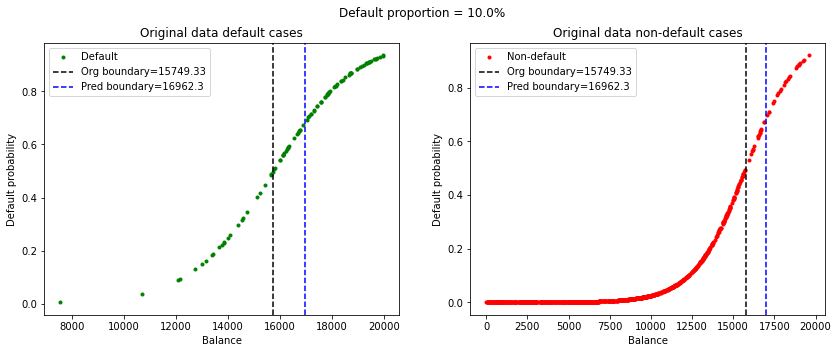

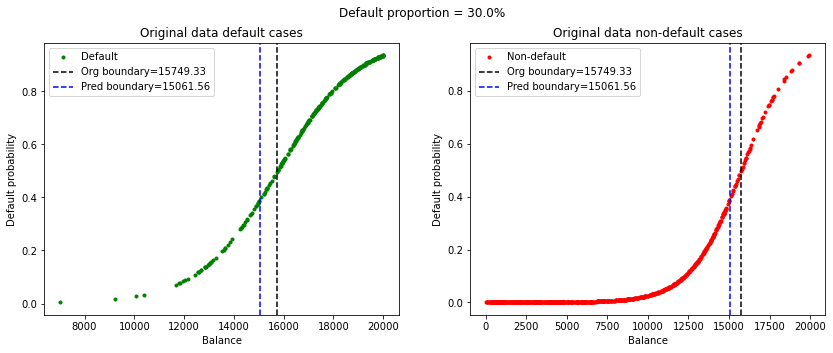

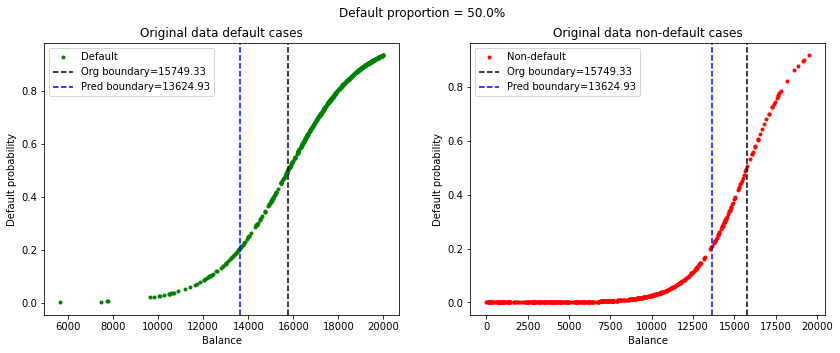

In [182]:
decisionBoundaries((0.1,0.3,0.5),orgDecisionBoundary)

### About the figures above -

The three rows of figures are respectively for the 10, 30 and 50 percent default=yes proportion in the data. The left hand plots show the original data for which default=yes in green. The right hand plots show the original data where default=no in red. In each figure the back vertical line shows the decision boundary governed by the simulating function; it stays the same throughout. The blue vertical line shows the predicted decision boundary.

### First, we go through the 3 left hand plots where only default=yes cases are plotted. 

<b><i>At the top the default=yes proportion is 10%.</i></b>
<ul>
    <li>The cases to the left of the original decision boundary are the ones where probability for default is less than 50%; yet a default happens. That's nature's way of throwing in unavoidable random errors.</li> 
    <li>Had the prediction boundary been exactly the same as the original boundary it would have been an exact learning of nature by the model; best possible scenario. Even then, all data points to the left of the prediction boundary will be predicted as default=no yet originally have default=yes; this is the false negative error. When the prediction boundary is same as original boundary, the only false negative errors are those caused by unavoidable random error.</li> 
    <li>However, the prediction boundary lies to the right of the original boundary because the training set has low number of default=yes samples. <b>To motivate this point, had there been no default=yes samples the prediction boundary would have been to the extreme right, identifying all samples as default=no.</b></li>
    <li>This is the source of the higher than usual false negative rate; the prediction boundary being to the right of original boundary due to low proportion of default=yes or positive cases.</li>
    </ul>
    
<b><i>Below it in the second row, default=yes proportion is 30%.</i></b>
<ul>
    <li>As the default=yes sample proportion increases the prediction boundary moves left. <b>To motivate this movement, just imagine that all training samples were default=yes. The prediction boundary would have been to the extreme left predicting default=yes for all cases.</b></li>
    <li>As the prediction boundary moves to the left the false negative errors decrease. This would try to bring the overall error down.</li>
    </ul>
    
<b><i>At the bottom, where default=yes proportion is 50% -</i></b>
<ul>
    <li>The prediction boundary moves even more left, further decreasing the false negative errors.</li>
    </ul>

### Next, we go through the 3 right-hand figures where only default=no cases are plotted 

<b><i>At the top the default=yes proportion is 10%.</i></b>
<ul>
    <li>The cases to the right of the original decision boundary are the ones where probability for default is more than 50%; yet a default does not happen. Here this is the unavoidable random error.</li>
    <li>The prediction boundary is to the right of the original boundary. Cases to the right of the prediction boundary are the ones where defult=yes or y=1 is predicted yet originally default=no or y=0. These are the false positive errors.</li>
    </ul>
    
<b><i>Below it in the second row, default=yes proportion is 30%.</i></b>
<ul>
    <li>As the prediction boundary moves to the left the false positive errors increase. This would try to bring the overall error up.</li>
    </ul>
    
<b><i>At the bottom, where default=yes proportion is 50% -</i></b>
<ul>
    <li>The prediction boundary moves even more left, further increasing the false positive errors.</li>
    </ul>

### So in terms of the overall error rate as the default=yes proportion increases-

With the prediction boundary moving left, the false negative error goes down. However, the false positive error goes up. But here lies a very tricky point. 
<ul>
    <li>Look at the left hand figures. As the blues line moves left the number of cases to its left which constitute the false negative errors decrease. However, when the default=yes proportion is low the desity of these green points overall is low. Hence even with an appreciable left movement of the blue line, the decrease in the number of points to its left is low.</li>
    <li>Look at the right hand figures now. As the blue line moves left the number of cases to its right increases i.e., false positive errors increase. However, the density of the red dots overall is more. Hence the same left movement of the blue line might lead to a relatively larger increase in false positive errors.</li>
    <li>Hence in increasing default=yes samples from 10 to 30 percent the increase in false positive errors hopefully trump the decrease in false negative errors.</li>
    <li>However standing at a more balanced scenario when the density of the green dots has increased, say default=yes being 30%, the left-movement of the blue line might not give stark differences between the decrement of false negatives and increment of false positives. Thus moving from 30 to 50 percent the overall error rate might be relatively more constant.</li>
    <li>Check the <i>Errors vs positive proportion</i> figure now. The overall error rate initially rises then gradually stabilizes.</li>
    </ul>

<blockquote><b>Hence that concludes the first part of our study - does false negativity rate depend on dataset imbalance? The answer is yes it does.</b></blockquote>

## V. Do threshold limit manipulation and class-weights achieve the same end?

Towards this end, given an imbalanced training set we first draw an ROC curve, which gives the false positive vs true positive rates at various threshold levels. Now the performance of the classifier (as measured by false positive vs true positive) 
<ol>
    <li>on same training set without class weights</li>
    <li>on same training set with balanced class weights (which attempts to equalize both the response classes)</li>
    <li>on a different, perfectly balanced training set without class weights</li>
    </ol>
is plotted in the same figure.

In [184]:
trainingSet = generateTrainingSet(1000,0.1,defaultProbabilityDist,np.random.uniform,low=0.0,high=20000)

In [185]:
clf = LogisticRegression().fit(trainingSet[['Balance']],trainingSet['Default'])

In [186]:
clf.score(trainingSet[['Balance']],trainingSet['Default'])

0.938

In [187]:
confuMatrix = metrics.confusion_matrix(trainingSet['Default'], clf.predict(trainingSet[['Balance']]),normalize='true')

In [188]:
confuMatrix

array([[0.97444444, 0.02555556],
       [0.39      , 0.61      ]])

In [192]:
clfBalanced = LogisticRegression(class_weight='balanced').fit(trainingSet[['Balance']],trainingSet['Default'])
confuMatrixBalanced = metrics.confusion_matrix(trainingSet['Default'], clfBalanced.predict(trainingSet[['Balance']]),normalize='true')

In [196]:
trainingSetBal = generateTrainingSet(1000,0.5,defaultProbabilityDist,np.random.uniform,low=0.0,high=20000)
clfBalSet = LogisticRegression().fit(trainingSetBal[['Balance']],trainingSetBal['Default'])
confuMatrixBalSet = metrics.confusion_matrix(trainingSetBal['Default'], clfBalSet.predict(trainingSetBal[['Balance']]),normalize='true')
clfBalSet.score(trainingSetBal[['Balance']],trainingSetBal['Default'])

0.882

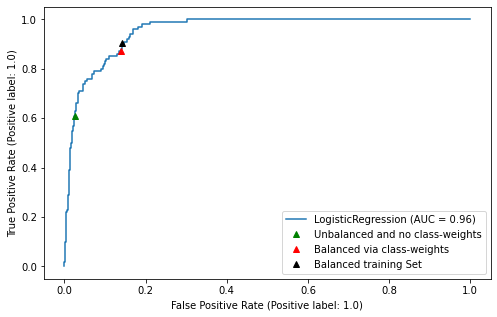

In [201]:
fig, ax = plt.subplots(figsize=(8,5))

metrics.plot_roc_curve(clf,trainingSet[['Balance']],trainingSet['Default'],ax=ax)
ax.plot(confuMatrix[0,1],confuMatrix[1,1],'^g',label='Unbalanced and no class-weights')
ax.plot(confuMatrixBalanced[0,1],confuMatrixBalanced[1,1],'^r',label='Balanced via class-weights')
ax.plot(confuMatrixBalSet[0,1],confuMatrixBalSet[1,1],'^k',label='Balanced training Set')
ax.legend();

<blockquote><b><i>The red dot, which is the case of balancing done via class-weights, lies on the blue curve thereby clarifying that balancing the datasets via class-weights achieves the same result as using a suitable threshold level. Besides, for this particluar case, using a balanced training set gave almost similar performance as an imbalanced dataset with balanced class-weights.</i></b></blockquote>


## VI. Conclusion


So it seems we have two options at our disposal with imbalanced sets.
<ol>
    <li>balance them via class-weights</li>
    <li>choose a suitable threshold</li>
    </ol>

I have some doubts regarding the first point though. Balancing via class-weights gives extra weightage to the few positive response samples. If those samples are indeed representative of the real world positive response class it's great. However, if those samples are corrupted, say due to incorrect measurements, then putting extra weightage on them can adversly affect the test set performance of the model. The same challenge possiby does not exist for threshold manipulation though. True, that this line of reasoning needs further empirical study, on test set performance, to be established. 